# Preprocessing

## Loading data / packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import bigfish.detection as detection

RUN_PATH = "/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Davide/2024-09-03 - SeqFISH_Run8 - HeLa_POLR2"
# RUN_PATH = '/media/floricslimani/SSD4To/SSD_floricslimani/Fish_seq/Davide/2024-08-12 - SeqFISH - HeLa - Puro - R2TP1-2_Run7/'
OUTPUT_PATH = RUN_PATH + "/analysis/density/"
os.makedirs(OUTPUT_PATH, exist_ok=True)

In [3]:
Acquisition = pd.read_feather(RUN_PATH + "/result_tables/Acquisition.feather")
Detection = pd.read_feather(RUN_PATH + "/result_tables/Detection.feather")
Spots = pd.read_feather(RUN_PATH + "/result_tables/Spots.feather")
Gene_map = pd.read_feather(RUN_PATH + "/result_tables/Gene_map.feather")

## Data merge

In [4]:
check_len = len(Detection)
Detection = pd.merge(
    Detection,
    Acquisition.loc[:,['acquisition_id', 'cycle', 'location']],
    on= 'acquisition_id',
    suffixes=('','_acquisition')
)
assert len(Detection) == check_len

Detection = pd.merge(
    Detection,
    Gene_map.loc[:,['cycle','color_id','target']],
    on= ['cycle','color_id']
)
assert len(Detection) == check_len

check_len = len(Spots)
Spots = pd.merge(
    Spots,
    Detection.loc[:,['detection_id', 'acquisition_id', 'target', 'location']],
    on= 'detection_id'
)
assert len(Spots) == check_len


# General clustering

Here we perform DBSCAN algorithm by pulling together spots from all channels so as to identify site of interaction between channels

- can we produce a 3D heatmap showing density of spots per pixel ?
- add new multichannel clusters to viewer
- additional graph analysis

*Note : functional version of this code available in **density.py***

## Post-processing

### Parameters

In [5]:
VOXEL_SIZE = tuple(Detection['voxel_size'].iat[0])
VOXEL_SIZE = [int(i) for i in VOXEL_SIZE]

MIN_NB_CLUSTER = 3 # Number for multiRNA cluster analysis

CLUSTER_RADIUS = max(VOXEL_SIZE) # Colocalization analysis
# CLUSTER_RADIUS = Detection['cluster_size'].iat[0] # regular clustering

### Pooling data

In [6]:
spots_coordinates_per_fov = Spots.groupby(['location']).agg({
    'z' : list,
    'y' : list,
    'x' : list,
    })
spots_coordinates_per_fov

,z,y,x
location,,,
Location-01,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 77, 141, 144, 265, 282, 284, 291, 305, 349...","[597, 389, 993, 1107, 673, 617, 575, 208, 648,..."
Location-02,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[4, 26, 35, 40, 46, 53, 54, 56, 74, 105, 118, ...","[1266, 531, 1282, 1559, 1236, 1234, 693, 556, ..."
Location-03,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 2, 8, 20, 32, 64, 79, 84, 84, 86, 89, 96, ...","[221, 214, 699, 1219, 640, 728, 942, 962, 1309..."
Location-04,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 7, 14, 15, 21, 22, 27, 28, 29, 33, 33, ...","[262, 333, 494, 266, 0, 1104, 847, 8, 350, 332..."
Location-05,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 10, 16, 76, 77, 94, 96, 97, 103, 111, 112,...","[1043, 1018, 1047, 1004, 1146, 1316, 1094, 110..."
Location-06,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 10, 28, 32, 33, 127, 170, 174, 244, 248, 2...","[40, 92, 100, 0, 77, 837, 1146, 1200, 254, 62,..."
Location-07,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[71, 71, 74, 79, 90, 91, 100, 103, 116, 117, 1...","[1894, 1959, 1861, 1954, 1911, 1961, 1829, 188..."
Location-08,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 128, 137, 143, 158, 160, 178, 211, 215, 22...","[25, 716, 668, 693, 598, 520, 668, 609, 625, 5..."
Location-09,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[14, 50, 56, 60, 60, 104, 117, 119, 119, 122, ...","[1949, 1755, 1711, 1757, 1762, 1900, 1861, 184..."


### DBSCAN

In [7]:
Spots_clustered = pd.DataFrame(columns=['cluster_id','z','y','x', 'location'])
for location in spots_coordinates_per_fov.index : 
    data_selec = spots_coordinates_per_fov.loc[location]

    spots = np.array(
        list(zip(data_selec['z'],data_selec['y'],data_selec['x'],)),
        dtype=int)

    clustered_spot, clusters = detection.detect_clusters(
        spots,
        VOXEL_SIZE,
        CLUSTER_RADIUS,
        MIN_NB_CLUSTER,
    )

    z,y,x, cluster_id = zip(*clustered_spot)
    cluster_z, cluster_y, cluster_x, spot_number, cluster_index = zip(*clusters)

    new_Spots_clustered = pd.DataFrame({
            'cluster_id' : cluster_id,
            'z' : z,
            'y' : y,
            'x' : x,
            'location' : location,
        })
    
    new_Clusters = pd.DataFrame({
        'cluster_id' : cluster_index,
        'cluster_centroid_z' : cluster_z, 
        'cluster_centroid_y' : cluster_y, 
        'cluster_centroid_x' : cluster_x, 
    })

    check_len = len(new_Spots_clustered)
    new_Spots_clustered = pd.merge(
        new_Spots_clustered,
        new_Clusters,
        on='cluster_id',
        how='left',
        validate='m:1'
    )
    assert len(new_Spots_clustered) == check_len , "check for duplication"

    Spots_clustered = pd.concat([
        Spots_clustered,
        new_Spots_clustered,
    ], axis= 0)

Spots_clustered

,cluster_id,z,y,x,location,cluster_centroid_z,cluster_centroid_y,cluster_centroid_x
0,-1,0,0,597,Location-01,NaN,NaN,NaN
1,-1,0,77,389,Location-01,NaN,NaN,NaN
2,-1,0,141,993,Location-01,NaN,NaN,NaN
3,-1,0,144,1107,Location-01,NaN,NaN,NaN
4,-1,0,265,673,Location-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
37515,-1,42,1542,503,Location-10,NaN,NaN,NaN
37516,-1,42,1656,934,Location-10,NaN,NaN,NaN
37517,-1,43,1786,1581,Location-10,NaN,NaN,NaN
37518,-1,43,1048,1822,Location-10,NaN,NaN,NaN


### Duplicated values after clustering

This dataframe is expected to contain duplicated values for spots with perfect colocalization. What is important for downstream analysis is that they have the same cluster_id. Next step is to retrieve this cluster id to the main Spots table, to avoid duplication during merge on coordinates, we remove duplicated rows.

In [8]:
Spots_clustered[Spots_clustered.duplicated()]

,cluster_id,z,y,x,location,cluster_centroid_z,cluster_centroid_y,cluster_centroid_x
1764,-1,1,380,1212,Location-01,NaN,NaN,NaN
1781,5,1,867,383,Location-01,1.0,867.0,383.0
1796,-1,0,1040,538,Location-01,NaN,NaN,NaN
1812,6,0,1115,779,Location-01,0.0,1115.0,779.0
1816,-1,2,1114,747,Location-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
37017,-1,15,600,63,Location-10,NaN,NaN,NaN
37129,296,20,844,501,Location-10,19.0,844.0,501.0
37242,-1,29,513,39,Location-10,NaN,NaN,NaN
37431,-1,38,482,251,Location-10,NaN,NaN,NaN


In [9]:
prev_len = len(Spots_clustered)
Spots_clustered = Spots_clustered.drop_duplicates()
print("{0} duplicates dropped.".format(prev_len - len(Spots_clustered)))

5309 duplicates dropped.


### Merging data into main Spots frame

In [10]:
check_len = len(Spots) #No filter/duplication expected.

Spots_clustered = Spots_clustered.rename(columns={'cluster_id' : 'general_cluster_id'})
print("clustered :",len(Spots_clustered))

Spots = pd.merge(
    Spots,
    Spots_clustered,
    on=['location','z','y','x'],
    validate= 'm:1'
)

assert len(Spots) == check_len
Spots

clustered : 333700


,spot_id,cluster_id,z,y,x,intensity,population,detection_id,acquisition_id,target,location,general_cluster_id,cluster_centroid_z,cluster_centroid_y,cluster_centroid_x
0,0,NaN,0,0,597,5927,free,1,0,POLR2A,Location-01,-1,NaN,NaN,NaN
1,1,NaN,0,77,389,6095,free,1,0,POLR2A,Location-01,-1,NaN,NaN,NaN
2,2,NaN,0,141,993,6923,free,1,0,POLR2A,Location-01,-1,NaN,NaN,NaN
3,3,NaN,0,144,1107,6960,free,1,0,POLR2A,Location-01,-1,NaN,NaN,NaN
4,4,NaN,0,265,673,7111,free,1,0,POLR2A,Location-01,-1,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339004,339004,NaN,42,1542,503,4187,free,208,189,POLR2L,Location-10,-1,NaN,NaN,NaN
339005,339005,NaN,42,1656,934,4044,free,208,189,POLR2L,Location-10,-1,NaN,NaN,NaN
339006,339006,NaN,43,1786,1581,4024,free,208,189,POLR2L,Location-10,-1,NaN,NaN,NaN
339007,339007,NaN,43,1048,1822,3599,free,208,189,POLR2L,Location-10,-1,NaN,NaN,NaN


# Analysis

### Data grouping

In [11]:
Clustered_spots = Spots.loc[Spots['general_cluster_id'] != -1]

multichannel_clusters = Clustered_spots.groupby(['location', 'general_cluster_id']).aggregate({
    'spot_id' : 'count',
    'target' : ['nunique','unique'],
    'cluster_centroid_z' : 'first',
    'cluster_centroid_y' : 'first',
    'cluster_centroid_x' : 'first',
})

multichannel_clusters.columns = pd.Index(['spot number', 'rna number', 'rna list', 'z', 'y', 'x'])

multichannel_clusters.to_excel(OUTPUT_PATH + "Multichannel_cluster.xlsx")
multichannel_clusters

spot number  rna number  \
location    general_cluster_id                            
Location-01 0                             6           4   
            1                             3           1   
            2                             3           1   
            3                             3           1   
            4                             3           1   
...                                     ...         ...   
Location-10 300                           3           1   
            301                           3           2   
            302                           3           1   
            303                           3           1   
            304                           3           1   

                                                        rna list     z  \
location    general_cluster_id                                           
Location-01 0                   [POLR2A, POLR2E, POLR2F, POLR2H]   0.0   
            1                                           [POLR2A]  13.0   
            2                                           [POLR2A]  18.0   
            3                                           [POLR2A]  18.0   
            4                                           [POLR2A]   2.0   
...                                                          ...   ...   
Location-10 300                                         [POLR2L]  42.0   
            301                                 [POLR2K, POLR2L]   2.0   
            302                                         [POLR2L]  11.0   
            303                                         [POLR2L]  21.0   
            304                                         [POLR2L]  28.0   

                                     y       x  
location    general_cluster_id                  
Location-01 0                    351.0   964.0  
            1                   1179.0   762.0  
            2                    524.0   145.0  
            3                   1446.0  1759.0  
            4                     43.0   542.0  
...                                ...     ...  
Location-10 300                 1299.0   621.0  
            301                 1001.0   491.0  
            302                   97.0  1859.0  
            303                 1497.0    30.0  
            304                 1389.0   242.0  

[3088 rows x 6 columns]

In [12]:
updated_spots = pd.merge(
    Spots,
    multichannel_clusters.loc[:,['rna number']],
    on=['location','general_cluster_id'],
)
assert len(Spots[Spots['general_cluster_id'] != -1]) == len(updated_spots), "Non unique (location,general_cluster_id)"
updated_spots

,spot_id,cluster_id,z,y,x,intensity,population,detection_id,acquisition_id,target,location,general_cluster_id,cluster_centroid_z,cluster_centroid_y,cluster_centroid_x,rna number
0,10,NaN,0,353,964,7341,free,1,0,POLR2A,Location-01,0,0.0,351.0,964.0,4
1,13795,NaN,0,353,964,10348,free,7,60,POLR2E,Location-01,0,0.0,351.0,964.0,4
2,13794,NaN,0,352,963,11054,free,7,60,POLR2E,Location-01,0,0.0,351.0,964.0,4
3,17617,NaN,0,350,965,10877,free,9,80,POLR2F,Location-01,0,0.0,351.0,964.0,4
4,17618,NaN,0,351,964,10644,free,9,80,POLR2F,Location-01,0,0.0,351.0,964.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12854,338379,9.0,12,97,1860,7029,clustered,208,189,POLR2L,Location-10,302,11.0,97.0,1859.0,1
12855,338383,9.0,11,97,1860,6880,clustered,208,189,POLR2L,Location-10,302,11.0,97.0,1859.0,1
12856,338579,10.0,21,1497,30,6526,clustered,208,189,POLR2L,Location-10,303,21.0,1497.0,30.0,1
12857,338580,10.0,21,1496,30,6371,clustered,208,189,POLR2L,Location-10,303,21.0,1497.0,30.0,1


## Filtering Washout spots and clusters

We filter all washout spots and clusters containing washout spots as they are very likely to be artifacts

In [13]:
query = updated_spots[updated_spots['target'].str.contains('Washout')].loc[:,['location','general_cluster_id']]
query

cluster_to_drop = pd.Series(zip(query['location'], query['general_cluster_id'])).unique()
cluster_to_drop
cluster_index = multichannel_clusters[multichannel_clusters.index.isin(cluster_to_drop)].index

spots_index = pd.Series(zip(updated_spots['location'], updated_spots['general_cluster_id']), index= updated_spots.index)
spots_index = updated_spots[spots_index.isin(cluster_to_drop)].index

updated_spots = updated_spots.drop(spots_index, axis=0)
multichannel_clusters = multichannel_clusters.drop(cluster_index, axis= 0)

print(
    f"{len(cluster_index)} clusters dropped.\n",
    f"{len(spots_index)} spots dropped."
)

125 clusters dropped.
 1826 spots dropped.


## General Plots

### Number of cluster with n number of RNA

In [14]:
cluster_plurality_number = multichannel_clusters['rna number'].unique()
cluster_plurality_number = list(cluster_plurality_number)
cluster_plurality_number.sort()
print(f"{len(cluster_plurality_number)} different size of cluster found.")
cluster_plurality_number

6 different size of cluster found.


[1, 2, 3, 4, 5, 6]

### Total rna number VS diversity of cluster

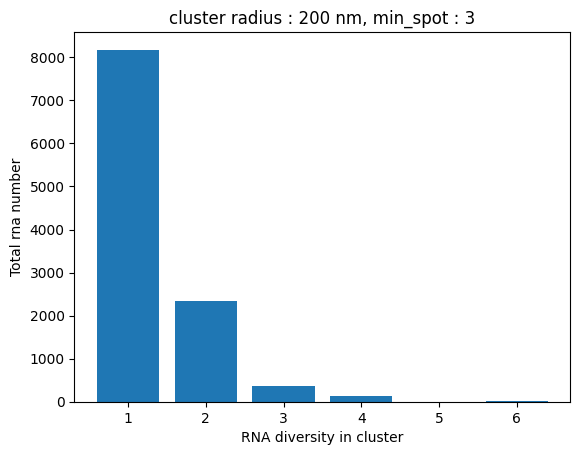

In [15]:
fig = plt.figure()
ax = fig.gca()

data = multichannel_clusters.groupby("rna number")['spot number'].sum()
ax.bar(data.index, data, align='center')
ax.set_xticks(data.index)
ax.set_ylabel("Total rna number")
ax.set_xlabel("RNA diversity in cluster")
ax.set_title(f"cluster radius : {CLUSTER_RADIUS} nm, min_spot : {MIN_NB_CLUSTER}")

plt.show()

### Total rna number per RNA per diversity

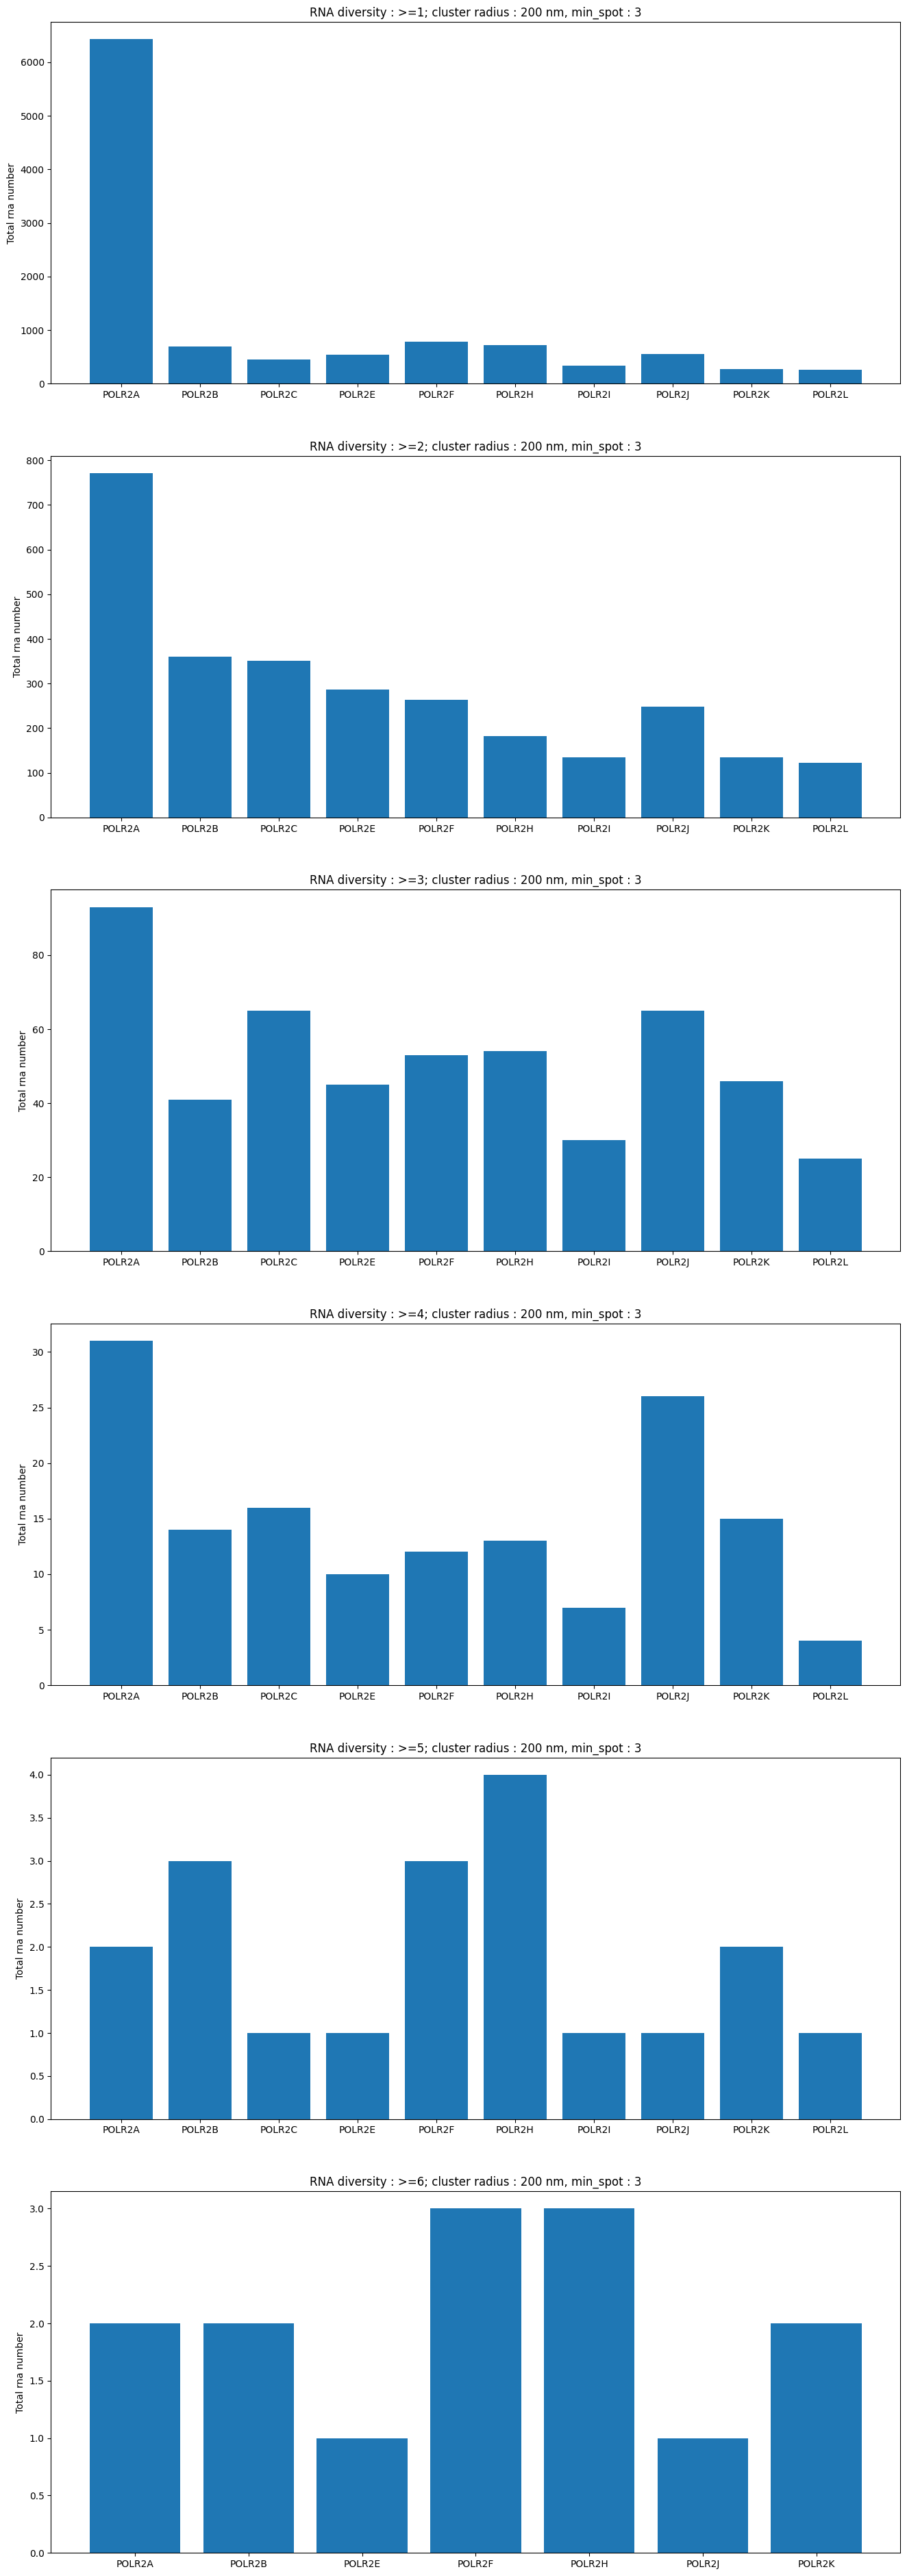

In [16]:
fig, axes = plt.subplots(nrows= len(cluster_plurality_number), ncols=1, figsize = (16,8*len(cluster_plurality_number)))

for ax, dimension in zip(axes, cluster_plurality_number) :
    ax:plt.Axes
    ax.set_title(f"RNA diversity : >={dimension}; cluster radius : {CLUSTER_RADIUS} nm, min_spot : {MIN_NB_CLUSTER}")

    data = updated_spots.loc[updated_spots['rna number'] >= dimension]
    data = data.groupby('target')['spot_id'].count()


    X = list(range(len(data)))
    ax.bar(X, data,align='center')
    ax.set_xticks(X, labels=data.index)
    ax.set_ylabel("Total rna number")

plt.show()

## Affinity & presence


### Cluster unity table

Here we build a DataFrame showing for each cluster the number of single molecules from each RNA in the dataset

In [17]:
MIN_DIVERSITY = 3

In [18]:
#Filtering spots from cluster with less than MIN_DIVERSITY different rnas.
data = updated_spots.loc[updated_spots['rna number'] >= MIN_DIVERSITY]

#Init empty table : each line is a cluster and each RNA of data set are reprensented in columns with their single molecule number in this cluster; init to 0.
cluster_list = pd.Series(zip(data['location'], data['general_cluster_id'])).unique()
cluster_list = pd.MultiIndex.from_tuples(cluster_list)
RNA_list = data['target'].unique()
cluster_unity_counts = pd.DataFrame(index=cluster_list, columns=RNA_list, dtype=int, data=0).sort_index()

#Creating table with all counts of single molecule per cluster per rna
agg_table = data.groupby(['location', 'general_cluster_id','target'])['spot_id'].count()
for location, cluster_id, rna in agg_table.index :
    value = agg_table.at[(location,cluster_id,rna)]
    cluster_unity_counts.loc[(location,cluster_id), rna] += value

#Assign values from groupby to cluster table
total = cluster_unity_counts.sum(axis=1).astype(int)
cluster_unity_counts

POLR2A  POLR2E  POLR2F  POLR2H  POLR2B  POLR2C  POLR2I  \
Location-01 0         1       2       2       1       0       0       0   
            90        0       0       1       0       0       1       0   
            104       0       1       1       0       0       2       0   
            109       0       0       0       0       0       6       0   
            113       0       1       0       1       0       0       0   
...                 ...     ...     ...     ...     ...     ...     ...   
Location-10 172       1       1       0       0       0       1       0   
            213       0       0       0       0       2       2       0   
            233       0       0       0       0       1       2       0   
            260       0       1       0       1       0       0       0   
            294       0       0       0       0       0       1       0   

                 POLR2J  POLR2K  POLR2L  
Location-01 0         0       0       0  
            90        0       1       0  
            104       0       0       0  
            109       2       0       1  
            113       0       1       0  
...                 ...     ...     ...  
Location-10 172       0       0       0  
            213       0       0       1  
            233       2       3       0  
            260       0       1       0  
            294       1       0       1  

[109 rows x 10 columns]

### Affinity & Presence tables

In [19]:
presence_dict = {}
affinity_dict = {}

for rna in RNA_list :
    rna_index = cluster_unity_counts.loc[cluster_unity_counts[rna] > 0].index
    data = cluster_unity_counts.loc[rna_index]

    affinity_df = data.apply(lambda x : x/total.loc[rna_index])
    affinity_df_total = affinity_df.sum(axis=1).round(10)
    assert (affinity_df_total == 1).all(), affinity_df[affinity_df_total != 1]
    affinity_dict[rna] = affinity_df

    presence_df = data.apply(lambda x : x.astype(bool))
    presence_dict[rna] = presence_df



presence_df


POLR2A  POLR2E  POLR2F  POLR2H  POLR2B  POLR2C  POLR2I  \
Location-01 109   False   False   False   False   False    True   False   
            160   False   False   False   False   False   False    True   
            175   False   False   False    True   False   False   False   
            186   False   False    True   False   False   False   False   
            204   False    True   False   False   False   False   False   
Location-02 164   False   False   False    True    True    True    True   
            241   False   False   False    True   False   False   False   
            242   False   False   False    True   False   False   False   
Location-03 307   False   False    True    True   False   False   False   
            348   False   False   False   False   False   False   False   
Location-04 312   False   False   False   False   False   False   False   
Location-05 227    True   False   False   False   False   False   False   
Location-06 329   False   False   False   False   False   False    True   
            334   False   False   False   False   False   False   False   
            338   False   False   False   False   False   False   False   
            366   False   False   False   False   False   False    True   
Location-07 226   False    True   False   False   False    True   False   
            244   False    True    True   False   False   False   False   
Location-08 196    True    True   False   False    True   False   False   
            317   False   False   False   False   False   False   False   
Location-10 213   False   False   False   False    True    True   False   
            294   False   False   False   False   False    True   False   

                 POLR2J  POLR2K  POLR2L  
Location-01 109    True   False    True  
            160    True   False    True  
            175    True   False    True  
            186   False    True    True  
            204    True   False    True  
Location-02 164   False   False    True  
            241   False    True    True  
            242   False    True    True  
Location-03 307   False   False    True  
            348    True    True    True  
Location-04 312    True    True    True  
Location-05 227    True   False    True  
Location-06 329    True    True    True  
            334    True    True    True  
            338    True    True    True  
            366    True   False    True  
Location-07 226   False   False    True  
            244   False   False    True  
Location-08 196   False   False    True  
            317    True    True    True  
Location-10 213   False   False    True  
            294    True   False    True

### Presence plots

Shows for each rna when it was found in a cluster of often other RNA were found in that cluster

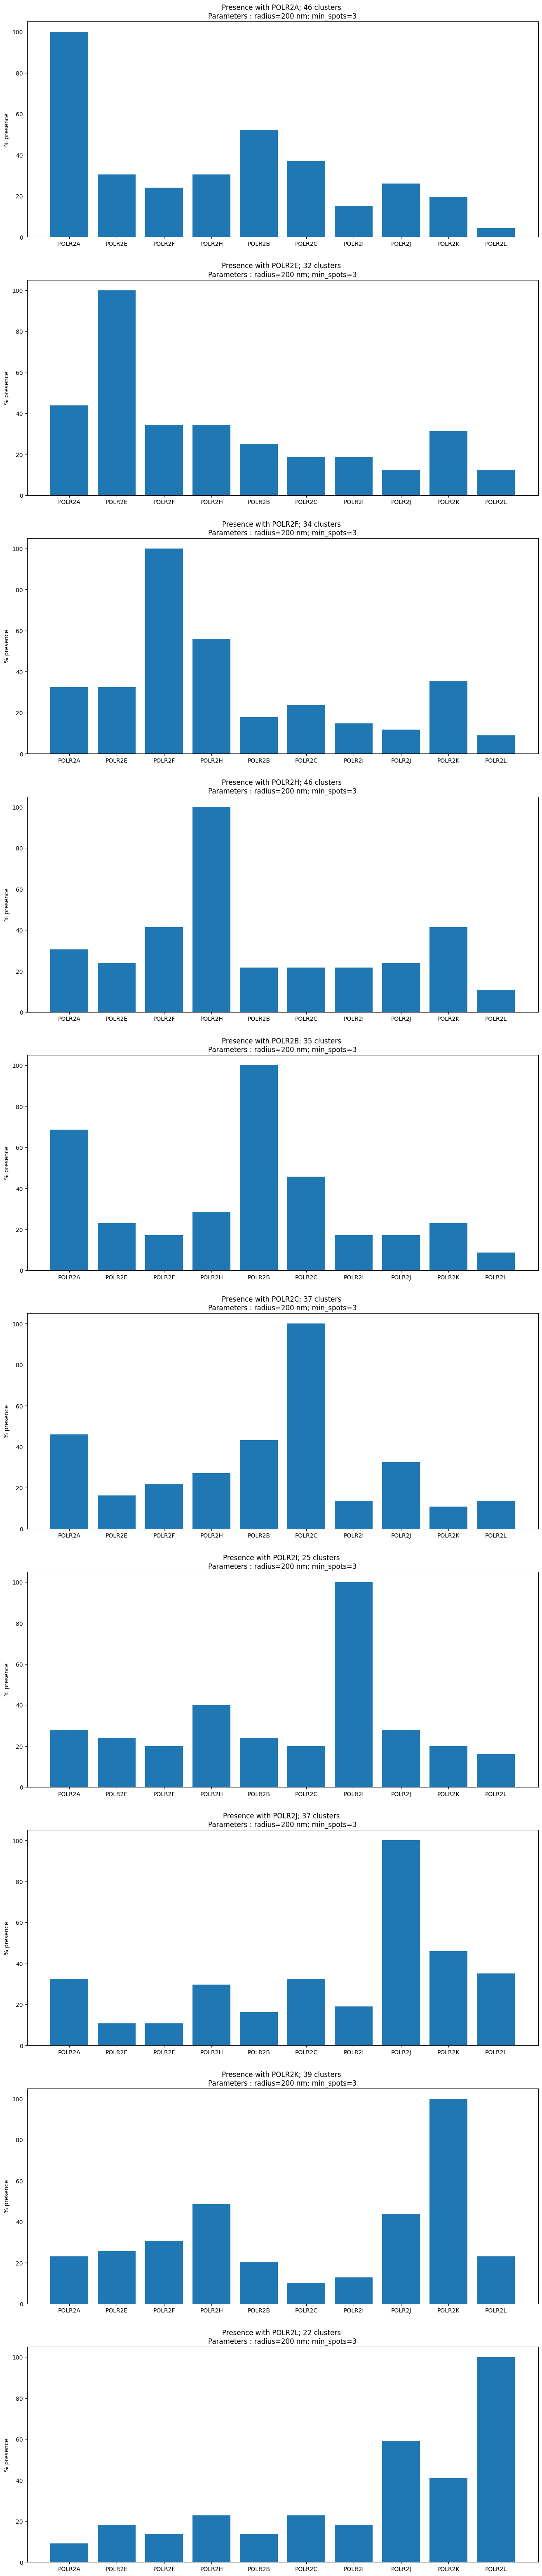

In [25]:
fig, axes = plt.subplots(nrows=len(RNA_list), ncols=1, figsize= (16,8*len(RNA_list)))

for ax, rna in zip(axes, RNA_list) :
    ax : plt.Axes

    data : pd.DataFrame = presence_dict[rna]
    cluster_number = len(data)
    data = data.sum(axis=0) / cluster_number * 100

    ax.set_title(f"Presence with {rna}; {cluster_number} clusters \nParameters : radius={CLUSTER_RADIUS} nm; min_spots={MIN_NB_CLUSTER}")
    ax.bar(data.index, data)
    ax.set_ylabel("% presence")

plt.show()

### Affinity plots

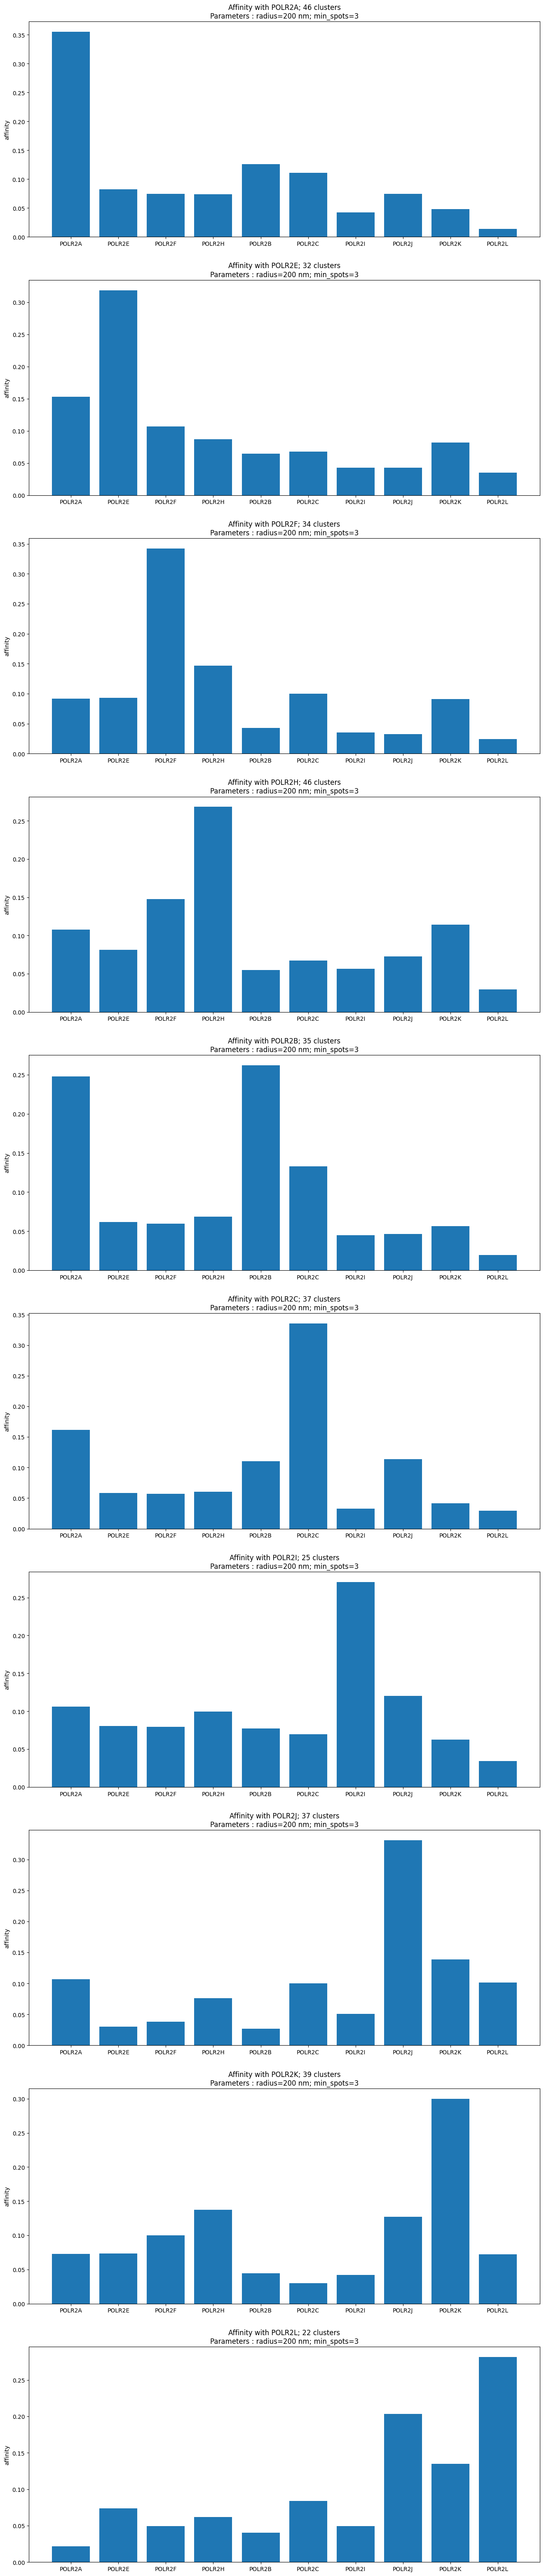

In [26]:
fig, axes = plt.subplots(nrows=len(RNA_list), ncols=1, figsize= (16,8*len(RNA_list)))

for ax, rna in zip(axes, RNA_list) :
    ax : plt.Axes

    data : pd.DataFrame = affinity_dict[rna]
    cluster_number = len(data)
    data = data.mean(axis=0)
    data_std = data.std(axis=0)

    ax.set_title(f"Affinity with {rna}; {cluster_number} clusters\nParameters : radius={CLUSTER_RADIUS} nm; min_spots={MIN_NB_CLUSTER}")
    ax.bar(data.index, data)
    ax.set_ylabel("affinity")

plt.show()